### Challenge

Predict which students took the test just for training purpose

#### Loading libraries

In [1]:
import pycaret
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
from pycaret.classification import *

### Loading datasets

In [2]:
# Train dataset
df_train = pd.read_csv('train.csv')
# Test dataset
df_test = pd.read_csv('test.csv')

# Creating answer dataframe
answer = pd.DataFrame()

### Exploratory data analysis

In [3]:
# Saving the registration number:
answer['NU_INSCRICAO'] = df_test['NU_INSCRICAO']

In [4]:
# Droping the registration number from train and test dataframes:
df_train.drop(['NU_INSCRICAO'], axis=1, inplace=True)
df_test.drop(['NU_INSCRICAO'],axis=1, inplace=True)

In [5]:
# Checking dataframe shape
df_train.shape, df_test.shape

((13730, 166), (4570, 42))

In [6]:
#By checking the shape of the datasets we can see that there are more columns in the training data than in the 
#test data, so we will use only the features that exist in the test dataframe to analyze and determine which 
#features we should use to make the prediction.

cols = list(df_test)
cols.append('IN_TREINEIRO')

train = df_train[cols]
test = df_test

In [7]:
# Viewing training data:
train.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,IN_TREINEIRO
0,43,RS,24,M,1,1,1,4,1,NaN,...,520.0,D,D,C,A,A,C,H,A,0
1,23,CE,17,F,3,1,2,0,2,1.0,...,580.0,A,A,B,A,A,A,NaN,A,0
2,23,CE,21,F,3,1,3,0,1,NaN,...,NaN,D,D,C,A,A,A,NaN,A,0
3,33,RJ,25,F,0,1,1,9,1,NaN,...,NaN,H,E,E,C,B,C,F,D,0
4,13,AM,28,M,2,1,1,4,1,NaN,...,NaN,E,D,C,A,A,B,F,A,0


In [8]:
# Viewing test data:
test.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,43,RS,19,F,1,1,1,3,1,NaN,...,NaN,NaN,E,E,H,B,B,C,D,A
1,15,PA,24,M,3,2,1,4,1,NaN,...,NaN,NaN,B,C,B,A,A,C,D,A
2,29,BA,16,F,2,1,3,0,1,NaN,...,NaN,NaN,E,F,G,B,B,A,NaN,D
3,41,PR,17,F,1,1,2,0,2,1.0,...,40.0,480.0,E,E,E,C,B,B,C,A
4,53,DF,19,F,1,1,1,1,1,NaN,...,80.0,720.0,E,E,E,B,B,B,D,A


In [9]:
# Selecting mannualy features for model, according with previously analysis
train = train[['NU_IDADE','TP_ST_CONCLUSAO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC','TP_PRESENCA_MT', 'IN_TREINEIRO']]
test = test[['NU_IDADE','TP_ST_CONCLUSAO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC','TP_PRESENCA_MT']]

In [10]:
# Creating a funtion to summarize dataframe information
def data_summary(df):
    '''Summary dataframe information'''

    df = pd.DataFrame({'type': df.dtypes,
                       'amount': df.isna().sum(),
                       'null_values (%)': (df.isna().sum() / df.shape[0]) * 100,
                       'unique': df.nunique()})
    return df

In [11]:
# Train summary:
data_summary(test)

,type,amount,null_values (%),unique
NU_IDADE,int64,0,0.0,47
TP_ST_CONCLUSAO,int64,0,0.0,4
TP_PRESENCA_CN,int64,0,0.0,2
TP_PRESENCA_CH,int64,0,0.0,2
TP_PRESENCA_LC,int64,0,0.0,3
TP_PRESENCA_MT,int64,0,0.0,3


In [12]:
# Train summary:
data_summary(train)

,type,amount,null_values (%),unique
NU_IDADE,int64,0,0.0,55
TP_ST_CONCLUSAO,int64,0,0.0,4
TP_PRESENCA_CN,int64,0,0.0,3
TP_PRESENCA_CH,int64,0,0.0,3
TP_PRESENCA_LC,int64,0,0.0,3
TP_PRESENCA_MT,int64,0,0.0,3
IN_TREINEIRO,int64,0,0.0,2


- *PS:* Students classified as 'Treineiros' are those who choose to take the tests even without having completed high school.

### Analysing target  "IN_TREINEIRO"

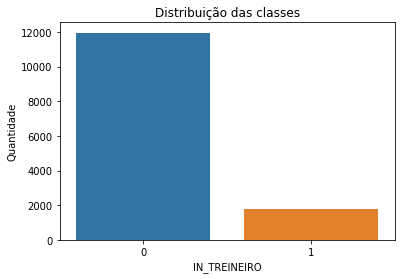

In [13]:
# Checking the distribution of the variable:
train['IN_TREINEIRO'].value_counts()
ax = sns.countplot(x='IN_TREINEIRO', data=train)
plt.ylabel('Quantidade')
plt.title('Distribuição das classes');

### Applying SMOTE (Synthetic Minority Over-sampling Technique)  method to deal with umbalanced classes

As observed previously, we are dealing with a problem of imbalanced classes. To fix it, we will use SMOTE method.

In [14]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [15]:
smt = SMOTE()
target = train['IN_TREINEIRO']
type(target)

pandas.core.series.Series

In [16]:
# Applying SMOTE to data:
train, target = smt.fit_sample(train, target)

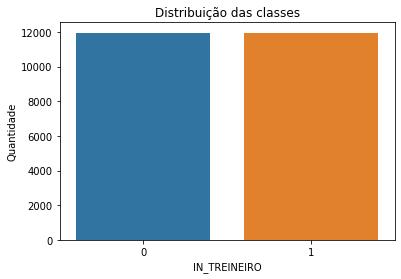

In [17]:
# Checking class distribution
np.bincount(target)
ax = sns.countplot(x=target)
plt.ylabel('Quantidade')
plt.title('Distribuição das classes');

### Creating a model by using *Pycaret* library

PyCaret is an open source, low-code machine learning library in Python that aims to reduce the cycle time from hypothesis to insights. It is well suited for seasoned data scientists who want to increase the productivity of their ML experiments by using PyCaret in their workflows or for citizen data scientists and those new to data science with little or no background in coding. PyCaret allows you to go from preparing your data to deploying your model within seconds using your choice of notebook environment.
Check more info [here](https://pycaret.org/guide/).

####  1- Seting up parameters:

- `setup()` function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. It must called before executing any other function and takes two mandatory parameters: dataframe {array-like, sparse matrix} and name of the target column. All other parameters are optional.


- **data:** train data.

- **target:** target feature.

- **remove_multicollinearity:** When set to True, the variables with inter-correlations higher than the threshold defined under the multicollinearity_threshold are dropped. When two features are highly correlated with each other, the feature that is less correlated with the target variable is dropped.

- **multicollinearity_threshold:** Threshold used for dropping the correlated features. 

- **normalize:** When set to True, the feature space is transformed using the normalized_method param. Generally, linear algorithms perform better with normalized data however,  the results may vary and it is advised to run multiple experiments to evaluate the benefit of normalization. 

- **normalize_method:** Defines the method to be used for normalization. 

- **transformation:** When set to True, a power transformation is applied to make the data more normal / Gaussian-like. This is useful for modeling issues related to heteroscedasticity or other situations where normality is desired. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood.

- **session_id:** If None, a random seed is generated and returned in the Information grid. The unique number is then distributed as a seed in all functions used during the experiment. This can be used for later reproducibility of the entire experiment.

In [18]:
# Creating a pipeline to setup the model
pipeline = setup(data=train, 
                 target='IN_TREINEIRO',
                 normalize = True, 
                 normalize_method = 'minmax',
                 transformation = True, 
                 ignore_low_variance = True,
                 remove_multicollinearity = True, 
                 multicollinearity_threshold = 0.95,
                 session_id=123)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(23894, 7)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### 2 - Comparing classification models

- `compare_models()` function train all the models available in the model library and scores them using Stratified Cross Validation. The output prints a score grid with Accuracy, AUC, Recall, Precision, F1, Kappa and MCC (averaged accross folds), determined by fold parameter.
- It returns the best model based on metric defined in sort parameter.

In [19]:
model = compare_models()

In [20]:
#best = compare_models(sort = 'AUC') #default is 'Accuracy'

#### 3 - Creating a model

- `create_model()` function creates a model and scores it using Stratified Cross Validation.The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1, Kappa and MCC by fold (default = 10 Fold). This function returns a trained model object. 

In [21]:
clf = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9934,0.9999,0.9881,0.9988,0.9934,0.9869
1,0.9892,0.9998,0.9821,0.9964,0.9892,0.9785
2,0.9910,0.9998,0.9857,0.9964,0.9910,0.9821
3,0.9904,0.9998,0.9856,0.9952,0.9904,0.9809
4,0.9910,0.9998,0.9880,0.9940,0.9910,0.9821
5,0.9898,0.9998,0.9833,0.9964,0.9898,0.9797
6,0.9892,0.9999,1.0000,0.9789,0.9893,0.9785
7,0.9892,0.9998,0.9809,0.9976,0.9891,0.9785
8,0.9946,0.9999,0.9904,0.9988,0.9946,0.9892
9,0.9928,0.9999,0.9880,0.9976,0.9928,0.9856


#### 4 - Model Tunning

- `tune_model()` function tunes the hyperparameters of a model and scores it using Stratified Cross Validation. The output prints a score grid that shows Accuracy, AUC, Recall Precision, F1, Kappa, and MCCby fold (by default = 10 Folds). This function returns a trained model object.

In [22]:
clf_tuned = tune_model('dt', optimize = 'AUC') #default is 'Accuracy'

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9934,0.9999,0.9881,0.9988,0.9934,0.9869
1,0.9892,0.9998,0.9821,0.9964,0.9892,0.9785
2,0.9910,0.9998,0.9857,0.9964,0.9910,0.9821
3,0.9904,0.9998,0.9856,0.9952,0.9904,0.9809
4,0.9910,0.9998,0.9880,0.9940,0.9910,0.9821
5,0.9898,0.9998,0.9833,0.9964,0.9898,0.9797
6,0.9892,0.9999,1.0000,0.9789,0.9893,0.9785
7,0.9892,0.9998,0.9809,0.9976,0.9891,0.9785
8,0.9946,0.9999,0.9904,0.9988,0.9946,0.9892
9,0.9928,0.9999,0.9880,0.9976,0.9928,0.9856


#### 4 - Model Calibration

- `calibrate_model()` function takes the input of trained estimator and performs probability calibration with sigmoid or isotonic regression. The output prints a score  grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold (default = 10 Fold). In order to see the calibration differences, use ‘calibration’ plot in plot_model to see the difference before and after.

In [23]:
clf_calibrated = calibrate_model(clf_tuned)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9934,0.9999,0.9881,0.9988,0.9934,0.9869
1,0.9892,0.9998,0.9821,0.9964,0.9892,0.9785
2,0.9910,0.9998,0.9857,0.9964,0.9910,0.9821
3,0.9904,0.9998,0.9856,0.9952,0.9904,0.9809
4,0.9910,0.9998,0.9880,0.9940,0.9910,0.9821
5,0.9898,0.9998,0.9833,0.9964,0.9898,0.9797
6,0.9940,0.9999,0.9892,0.9988,0.9940,0.9880
7,0.9892,0.9998,0.9809,0.9976,0.9891,0.9785
8,0.9946,0.9999,0.9904,0.9988,0.9946,0.9892
9,0.9928,0.9999,0.9880,0.9976,0.9928,0.9856


In [24]:
# Checking score after cross-validation:
predict_model(clf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Decision Tree Classifier,0.9883,0.9998,0.9827,0.9938,0.9882,0.9766


In [25]:
predict_model(clf_tuned);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Decision Tree Classifier,0.9883,0.9998,0.9827,0.9938,0.9882,0.9766


In [26]:
predict_model(clf_calibrated);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Calibrated Classifier C V,0.9883,0.9998,0.9827,0.9938,0.9882,0.9766


#### 5 - Analysing results

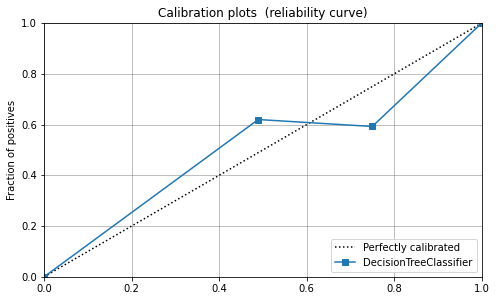

In [27]:
# Model before calibration
plot_model(clf_tuned, plot='calibration')

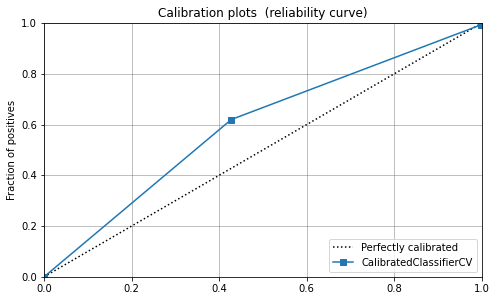

In [28]:
# Model Calibrated
plot_model(clf_calibrated, plot='calibration')

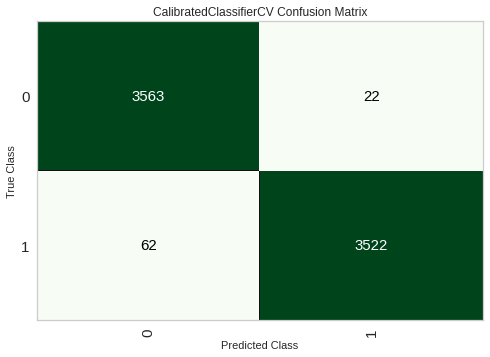

In [29]:
#  Confusion Matrix
plot_model(estimator = clf_calibrated, plot = 'confusion_matrix')

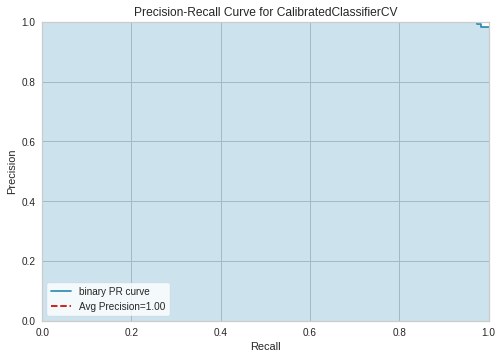

In [30]:
# Precision Recall Curve
plot_model(estimator = clf_calibrated, plot = 'pr')

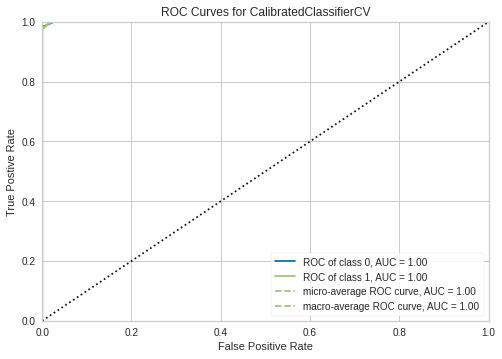

In [31]:
# AUC
plot_model(estimator = clf_calibrated, plot = 'auc')

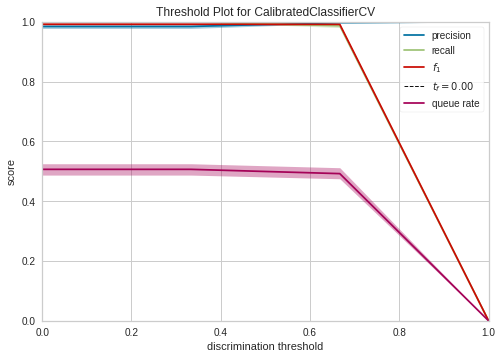

In [32]:
# Discrimination Threshold
plot_model(estimator = clf_calibrated, plot = 'threshold')

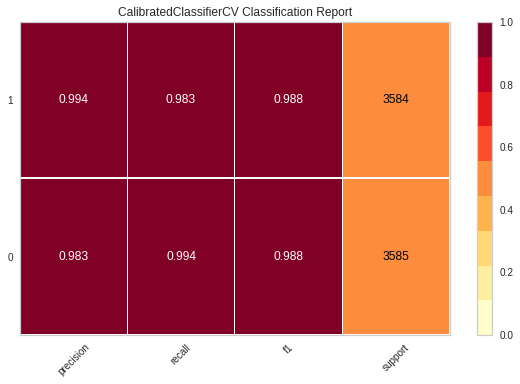

In [33]:
# Class report
plot_model(estimator = clf_calibrated, plot = 'class_report')

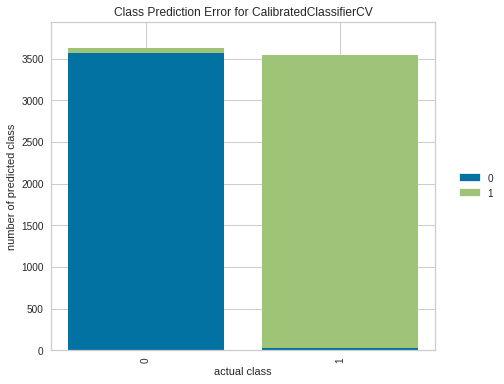

In [34]:
# Class Prediction Error
plot_model(estimator = clf_calibrated, plot = 'error')

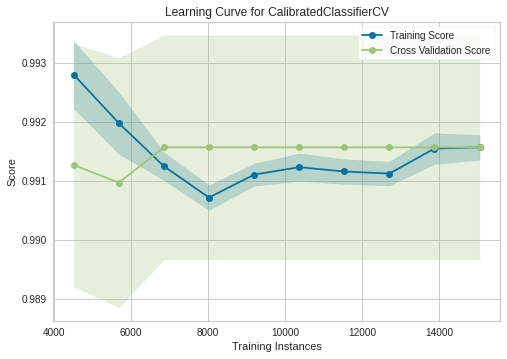

In [35]:
# Learning curve
plot_model(estimator = clf_calibrated, plot = 'learning')

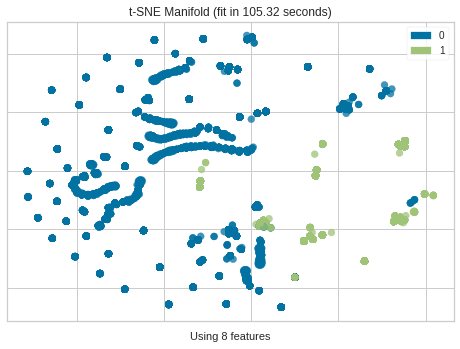

In [36]:
# Manifold Learning
plot_model(estimator = clf_calibrated, plot = 'manifold')

#### 6 - Predicting scores

- `predict_model()` is used to predict new data using a trained estimator. 

In [37]:
predictions = predict_model(clf_calibrated, data = test)

#### 7- Visualizing predictions is answer dataframe

In [38]:
answer = pd.DataFrame({'NU_INSCRICAO':  answer['NU_INSCRICAO'],  'IN_TREINEIRO':predictions['Label']})
answer

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0
...,...,...
4565,361b7fcd8867119550fe2af5aa729ffad89a7cf5,0
4566,d8a0e4c9e29494cc9bba2422bd79333931475ee1,0
4567,3f1c3388244df8d6521e983a809292d9f3bca643,0
4568,1778e9c4cef591beb6b986d191d15ed05de816b0,0


#### 8 - Storing results in a .csv file

In [39]:
answer.to_csv('answer.csv',index=False,header=True)